<a href="https://colab.research.google.com/github/pj0620/google-colab-notebooks/blob/main/ViNG_ai2thor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grab Ai2thor data from Gdrive

In [1]:
!pip install gdown

In [2]:
import gdown

file_id = "1jxyQ2mA7MVJEoc_eAKPAME3go2lI16Aj"
output = "ai2thor_data.npz"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output)

Downloading...
From (original): https://drive.google.com/uc?id=1jxyQ2mA7MVJEoc_eAKPAME3go2lI16Aj
From (redirected): https://drive.google.com/uc?id=1jxyQ2mA7MVJEoc_eAKPAME3go2lI16Aj&confirm=t&uuid=a5aaa35a-7b5b-423f-a2d1-79130223b685
To: /content/ai2thor_data.npz
100%|██████████| 2.95G/2.95G [00:18<00:00, 159MB/s]


'ai2thor_data.npz'

# Load & Preprocess data

In [4]:
import numpy as np

ai2thor_data = np.load("ai2thor_data.npz", mmap_mode="r")
images = ai2thor_data["images"][:10_000, :, :, :]
poses = ai2thor_data["poses"][:10_000, :]

(images, poses)

(array([[[[216, 213, 197],
          [216, 213, 196],
          [215, 213, 196],
          ...,
          [152, 151, 136],
          [152, 153, 138],
          [154, 156, 140]],
 
         [[214, 211, 194],
          [214, 213, 196],
          [215, 213, 196],
          ...,
          [151, 152, 137],
          [152, 154, 138],
          [155, 156, 140]],
 
         [[210, 207, 191],
          [214, 212, 194],
          [215, 213, 196],
          ...,
          [151, 152, 136],
          [152, 155, 138],
          [154, 156, 140]],
 
         ...,
 
         [[246, 237, 214],
          [241, 232, 209],
          [240, 232, 209],
          ...,
          [ 63,  69,  52],
          [ 55,  62,  45],
          [ 50,  60,  41]],
 
         [[246, 236, 214],
          [244, 236, 212],
          [247, 239, 215],
          ...,
          [ 66,  71,  55],
          [ 58,  64,  48],
          [ 53,  60,  43]],
 
         [[247, 240, 216],
          [245, 236, 213],
          [247, 238, 214],
   

## Normalizing

In [5]:
poses_no_height = np.delete(poses, 1, 1)
poses_no_height

mins = np.min(poses_no_height, axis=0)
maxes = np.max(poses_no_height, axis=0)

poses_normalized = (poses_no_height - mins) / (maxes - mins)
poses_normalized

array([[0.88888889, 0.7       , 0.3411191 ],
       [0.88888889, 0.9       , 0.23146405],
       [0.05555556, 0.8       , 0.14247362],
       ...,
       [0.05555556, 0.55      , 0.93942025],
       [0.72222222, 1.        , 0.41072233],
       [0.16666667, 0.9       , 0.48937067]])

In [6]:
images_normalized = images / 255
del images
images_normalized

array([[[[0.84705882, 0.83529412, 0.77254902],
         [0.84705882, 0.83529412, 0.76862745],
         [0.84313725, 0.83529412, 0.76862745],
         ...,
         [0.59607843, 0.59215686, 0.53333333],
         [0.59607843, 0.6       , 0.54117647],
         [0.60392157, 0.61176471, 0.54901961]],

        [[0.83921569, 0.82745098, 0.76078431],
         [0.83921569, 0.83529412, 0.76862745],
         [0.84313725, 0.83529412, 0.76862745],
         ...,
         [0.59215686, 0.59607843, 0.5372549 ],
         [0.59607843, 0.60392157, 0.54117647],
         [0.60784314, 0.61176471, 0.54901961]],

        [[0.82352941, 0.81176471, 0.74901961],
         [0.83921569, 0.83137255, 0.76078431],
         [0.84313725, 0.83529412, 0.76862745],
         ...,
         [0.59215686, 0.59607843, 0.53333333],
         [0.59607843, 0.60784314, 0.54117647],
         [0.60392157, 0.61176471, 0.54901961]],

        ...,

        [[0.96470588, 0.92941176, 0.83921569],
         [0.94509804, 0.90980392, 0.81960784]

## Test train split

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import numpy as np

import matplotlib.pyplot as plt

num_samples = images_normalized.shape[0]
image_size = (3, 128, 128)  # Channels x Height x Width
pose_size = 3  # Pose vector size x, z, angle


images_tensor = torch.tensor(images_normalized, dtype=torch.float32)
poses_tensor = torch.tensor(poses_normalized, dtype=torch.float32)

# Step 2: Create a dataset and split into train and test
dataset = TensorDataset(images_tensor, poses_tensor)

# Define split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size

# Perform train-test split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 3: Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Input channels = 3 (RGB)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Adjusted for output of conv2/pool layers
        self.fc2 = nn.Linear(128, 64)  # Output size = pose vector size
        self.fc3 = nn.Linear(64, 3)  # Output size = pose vector size

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN()

# Step 4: Define loss function and optimizer
criterion = nn.MSELoss()  # Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the model
num_epochs = 50

train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images_batch, poses_batch in train_loader:
        optimizer.zero_grad()
        images_batch = images_batch.permute(0, 3, 1, 2)
        outputs = model(images_batch)
        loss = criterion(outputs, poses_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0.0
    with torch.no_grad():
      for images_batch, poses_batch in test_loader:
          # Adjust input shape to (N, C, H, W)
          images_batch = images_batch.permute(0, 3, 1, 2)

          # Forward pass
          outputs = model(images_batch)

          # Compute loss
          loss = criterion(outputs, poses_batch)

          # Accumulate loss and MAE
          test_loss += loss.item()
          mae = torch.mean(torch.abs(outputs - poses_batch)).item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch: 0, Train Loss: 0.0559, Test Loss: 0.0238
Epoch: 1, Train Loss: 0.0168, Test Loss: 0.0134
Epoch: 2, Train Loss: 0.0105, Test Loss: 0.0115
Epoch: 3, Train Loss: 0.0075, Test Loss: 0.0089
Epoch: 4, Train Loss: 0.0055, Test Loss: 0.0072
Epoch: 5, Train Loss: 0.0044, Test Loss: 0.0060
Epoch: 6, Train Loss: 0.0037, Test Loss: 0.0065
Epoch: 7, Train Loss: 0.0031, Test Loss: 0.0055
Epoch: 8, Train Loss: 0.0023, Test Loss: 0.0068
Epoch: 9, Train Loss: 0.0023, Test Loss: 0.0051
Epoch: 10, Train Loss: 0.0019, Test Loss: 0.0047
Epoch: 11, Train Loss: 0.0019, Test Loss: 0.0048
Epoch: 12, Train Loss: 0.0020, Test Loss: 0.0044
Epoch: 13, Train Loss: 0.0016, Test Loss: 0.0041
Epoch: 14, Train Loss: 0.0016, Test Loss: 0.0041
Epoch: 15, Train Loss: 0.0017, Test Loss: 0.0041
Epoch: 16, Train Loss: 0.0014, Test Loss: 0.0042
Epoch: 17, Train Loss: 0.0016, Test Loss: 0.0041
Epoch: 18, Train Loss: 0.0015, Test Loss: 0.0039
Epoch: 19, Train Loss: 0.0028, Test Loss: 0.0051
Epoch: 20, Train Loss: 0.0015,

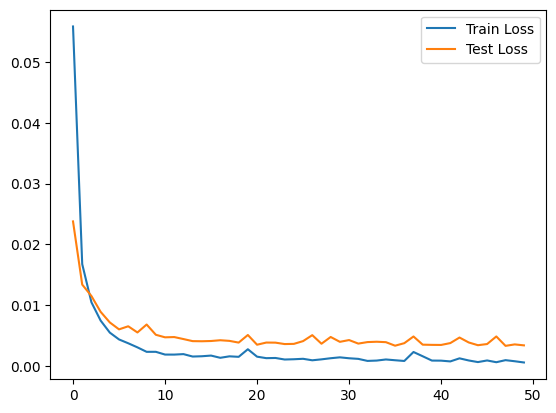

In [32]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.show()

## Validate with test data

In [33]:
test_mae = 0.0
test_loss = 0.0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images_batch, poses_batch in test_loader:
        # Adjust input shape to (N, C, H, W)
        images_batch = images_batch.permute(0, 3, 1, 2)

        # Forward pass
        outputs = model(images_batch)

        # Compute loss
        loss = criterion(outputs, poses_batch)

        # Accumulate loss and MAE
        test_loss += loss.item()
        mae = torch.mean(torch.abs(outputs - poses_batch)).item()
        test_mae += mae

# Compute average metrics for test set
avg_test_loss = test_loss / len(test_loader)
avg_test_mae = test_mae / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}, Test MAE: {avg_test_mae:.4f}")

Test Loss: 0.0034, Test MAE: 0.0294
